In [1]:
# from ..tests.test_bidiag_JVP_and_VJP_jax import bidiagonalize_vjpable
import jax
import jax.numpy as jnp
from jax import jit
from jax.experimental.ode import odeint
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from IPython.display import Image

In [2]:
from sklearn.datasets import fetch_lfw_people
import sys

sys.path.append("..")
from tests import test_bidiag_JVP_and_VJP_jax as bidiag_module
from arnoldi_bidiag import arnoldi_bidiag

import random
import matfree
from matfree.decomp import bidiag as bidiag_matfree

lfw_people = fetch_lfw_people(min_faces_per_person=10)


# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)


print("X.shape: ", X.shape)


Total dataset size:
n_samples: 4324
n_features: 2914
n_classes: 158
X.shape:  (4324, 2914)


In [3]:
def matvec(v, mat):
    return mat @ v


# X = np.random.randn(10, 10)

start_vec = jnp.asarray(X[0, :], dtype=float)
start_vec = (
    jax.random.normal(
        key=jax.random.PRNGKey(random.randint(1, 10**10)), shape=X.shape[1]
    )
    * 0
    + 1
)


matves = 20

result = bidiag_matfree(matves, materialize=True)(matvec, start_vec, X)
mL, mR = result.Q_tall
mB = result.J_small

bidiag_output = bidiag_module.bidiagonalize_vjpable_matvec(
    num_matvecs=matves, custom_vjp=True, reorthogonalize=True
)(matvec, start_vec, jnp.asarray(X))
L = bidiag_output.ls
B = jnp.diag(bidiag_output.alphas) + jnp.diag(bidiag_output.betas, 1)
R = bidiag_output.rs

norms = [
    np.linalg.norm(X - (L[:, :i] @ B[:i, :i] @ R[:, :i].T)) for i in range(1, matves, 1)
]
m_norms = [
    np.linalg.norm(X - (mL[:, :i] @ mB[:i, :i] @ mR[:, :i].T))
    for i in range(1, matves, 1)
]

arnodli_bidiag_output: arnoldi_bidiag.DecompResult = (
    arnoldi_bidiag.arnoldi_bidiagonalization(
        num_matvecs=matves, output_size=X.shape[0]
    )(matvec, start_vec, X)
)
aL = arnodli_bidiag_output.ls
aB = jnp.diag(arnodli_bidiag_output.as_) + jnp.diag(arnodli_bidiag_output.bs_, 1)
aR = arnodli_bidiag_output.rs

# a_norms = [
#     np.linalg.norm(X - (aL[:, :i] @ aB[:i, :i] @ aR[:, :i].T))
#     for i in range(1, matves, 1)
# ]
for title, _R, _L, _B in (
    ("arnoldi", aR, aL, aB),
    ("matfree", mR, mL, mB),
    ("theo", R, L, B),
):
    print(title)
    property = np.linalg.norm(X @ _R - _L @ _B)
    # print(f"{title}: {property:.2f}")
    # print(_R)

# plt.plot(norms, label="my reconstruction norms")
# plt.plot(m_norms, label="matfree reconstruction norms")
# plt.plot(a_norms, label="arnoldi reconstruction norms")
# plt.yscale("log")
# plt.legend()
# plt.show()

# for i in range(8):
#     fig, ax = plt.subplots(1, 4)
#     ax[0].imshow((L @ B @ R.T)[i, :].reshape(h, w))
#     ax[1].imshow((aL @ aB @ aR.T)[i, :].reshape(h, w))
#     ax[2].imshow((mL @ mB @ mR.T)[i, :].reshape(h, w))
#     ax[3].imshow(X[i].reshape(h, w))
#     titles = ["Custom bidiag", "Arnoldi bidiag", "Matfree bidiag", "original"]
#     [ax_.set_title(title) for ax_, title in zip(ax, titles)]
#     plt.show()


arnoldi
matfree
theo


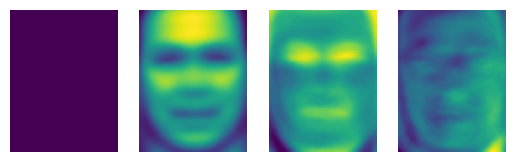

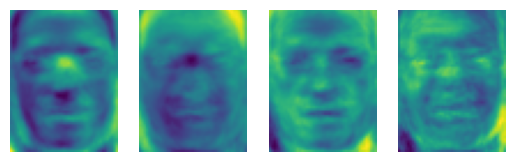

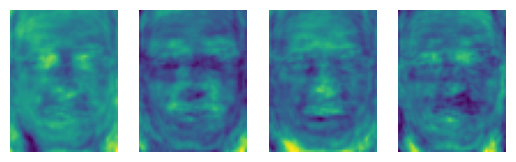

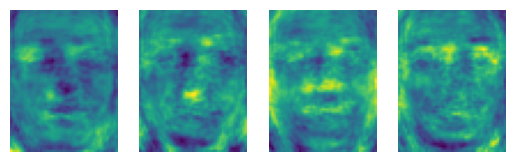

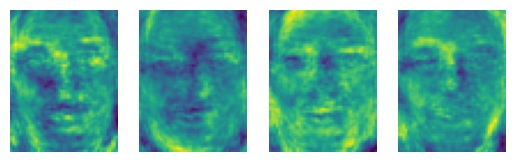

In [6]:
for i in range(5):
    fig, axs = plt.subplots(1, 4)
    [axs[j].imshow(R[:, i * 4 + j].reshape(h, w)) for j in range(4)]
    [axs[j].axis("off") for j in range(4)]

    plt.show()

[1800.80754427  188.03686255  152.3023551   143.61212596  107.46744949
   94.68400007   86.0385498    75.03164085   73.56039526   68.69135278
   65.41272957   58.50179359   53.84337332   48.95325219   41.47005008
   33.31045355   28.02557135   22.06343673   13.33988221    5.41396248]
[1775.18426169  127.02412154  103.24213472  142.7828615    57.0426893
  104.48233      75.28744291   64.66662754   49.69673004   53.86493608
   47.79406174   37.08935592   39.27324607   34.77878634   42.35211376
   41.19021097   32.29923939   40.93587709   30.41481864   34.87972182]


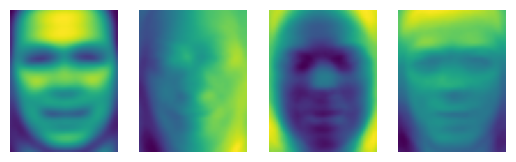

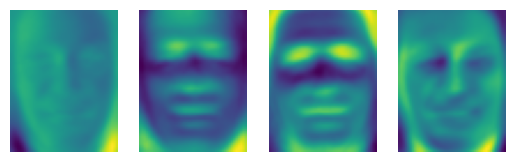

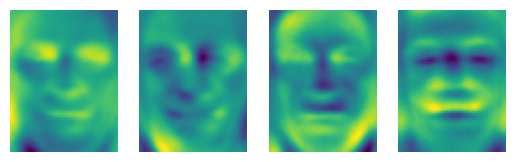

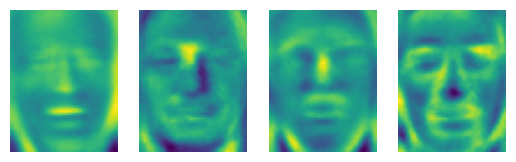

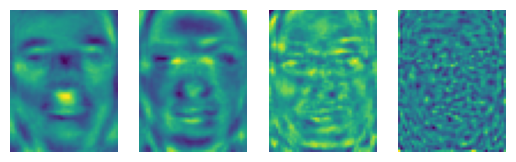

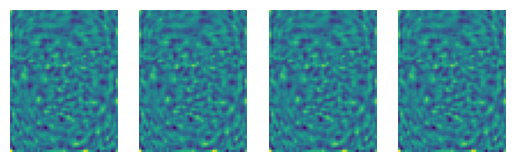

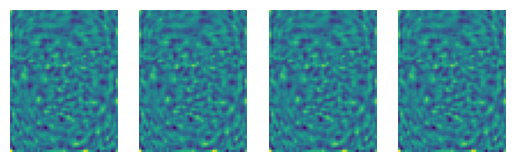

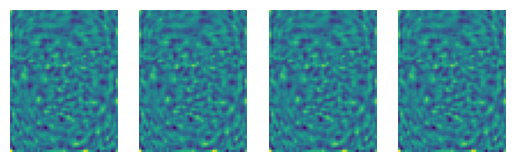

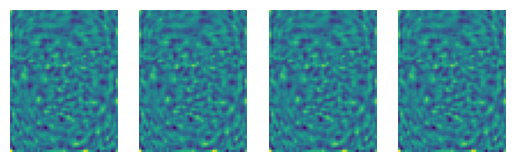

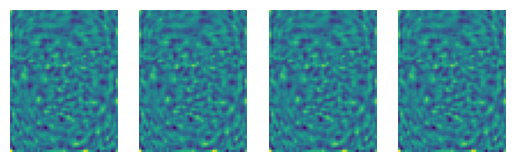

In [11]:
# L U S VT RT
U, S, VT = jnp.linalg.svd(aB)

p = (VT @ aR.T).T

print(S)
print(jnp.diag(aB))


for i in range(10):
    fig, axs = plt.subplots(1, 4)
    [axs[j].imshow(p[:, i * 4 + j].reshape(h, w)) for j in range(4)]
    [axs[j].axis("off") for j in range(4)]

    plt.show()
